In [1]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from nufft import *
from util.fft import *
from scipy import interpolate
from tqdm.notebook import tqdm
from scipy.spatial import Voronoi, ConvexHull, convex_hull_plot_2d, voronoi_plot_2d

In [2]:
gridsize = 256
trajectory = np.load("../lib/nufft_trajectory.npy")
data = np.load("../lib/nufft_data.npy")

(-0.05, 0.05)

<Figure size 640x480 with 0 Axes>

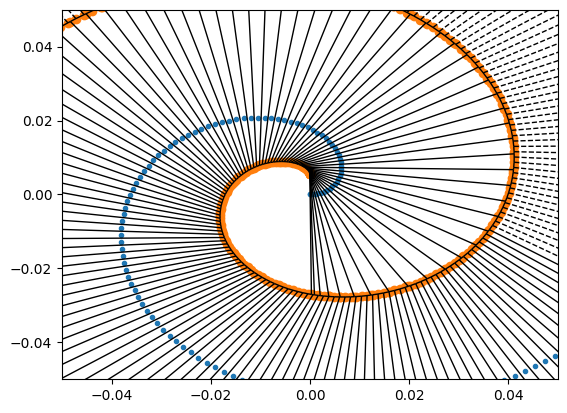

In [3]:
vor = Voronoi(trajectory[:300])
plt.figure()
voronoi_plot_2d(vor)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

In [5]:
# Generic kb kernel 
'''
Formula from Jack et al.(1991)
According to Jackson 1991, on selection of the colvolution kernel page 3
u is only defined for |u|<w/2  
The convolution kernel is symmetrical, so only half part is computed, and it is also 
presampled with oversampling ratio of 2 for faster computation, check Betty's paper for lower oversampling ratio. 
'''

def kb(u, width, beta):
    # kb function 
    # Auther: Zimu Huo
    u = beta*np.sqrt(1-(2*u/width)**2)
    u = np.i0(u)/width
    return u 



def KaiserBesselwindow(width, length,overgridfactor):
    # kb kernel
    # Auther: Zimu Huo
    w = width
    l = length
    alpha = overgridfactor
    beta = np.pi*np.sqrt(w**2/alpha**2*(alpha-1/2)**2-0.8)
    # from betty, 2005, on rapid griding algorithms 
    
    u = np.arange(0,l,1)/(l-1)*w/2
    #According to Jackson 1991, on selection of the colvolution kernel page 3
    #u is only defined for |u|<w/2

    window = kb(u, w, beta)
    window = window/window[0]

    return window




'''
standard griding
'''
def gridding(mat, data, traj, dcf,kernalwidth=5):
    # standard gridding function, perform convolution using nested for loops 
    # Auther: Zimu Huo
    gridsize = mat.shape[0]
    Kernallength = 32
    kernalwidth = kernalwidth
    window = KaiserBesselwindow(kernalwidth, Kernallength, 1.375)  
    kwidth = kernalwidth / 2 / gridsize
    gridcenter = gridsize / 2
    for n, weight in enumerate(dcf):
        kx = traj[n,0]
        ky = traj[n,1]
        xmin = int((kx - kwidth) * gridsize + gridcenter)
        xmax = int((kx + kwidth) * gridsize + gridcenter) + 1
        ymin = int((ky - kwidth) * gridsize + gridcenter)
        ymax = int((ky + kwidth) * gridsize + gridcenter) + 1
        if (xmin < 0):
            xmin = 0
        if (xmax >= gridsize):
            xmax = gridsize
        if (ymin < 0):
            ymin = 0
        if (ymax >= gridsize):
            ymax = gridsize
        for x in range(xmin, xmax):
            dx = (x - gridcenter) / gridsize - kx
            for y in range(ymin, ymax):
                dy = (y - gridcenter) / gridsize - ky
                d = np.sqrt(dx ** 2 + dy ** 2)
                if (d < kwidth):
                    idx = d / kwidth * (Kernallength - 1)
                    idxint = int(idx)
                    frac = idx - idxint
                    kernal = window[idxint] * (1 - frac) + window[idxint + 1] * frac
                    mat[x, y] += kernal * weight * data[n]
    return mat



'''
Equation 19
(W * phi) * R from  Jim Pipe et al. (1999)
It simply means convolving the weight with the kernel onto R, which is a Cartesian grid.
Complexity O(2pi L^2 N) 
'''
    
def grid(traj, dcf, gridsize = 256):
    # Gridding function 
    # Auther: Zimu Huo
    mat = np.zeros([gridsize, gridsize], dtype=complex)
    gridsize = mat.shape[0]
    Kernallength = 32
    kernalwidth = 5 
    window = KaiserBesselwindow(kernalwidth, Kernallength, 1.375)  
    kwidth = kernalwidth / 2 / gridsize
    gridcenter = gridsize / 2
    for n, weight in enumerate(dcf):
        kx = traj[n,0]
        ky = traj[n,1]
        xmin = int((kx - kwidth) * gridsize + gridcenter)
        xmax = int((kx + kwidth) * gridsize + gridcenter) + 1
        ymin = int((ky - kwidth) * gridsize + gridcenter)
        ymax = int((ky + kwidth) * gridsize + gridcenter) + 1
        if (xmin < 0):
            xmin = 0
        if (xmax >= gridsize):
            xmax = gridsize
        if (ymin < 0):
            ymin = 0
        if (ymax >= gridsize):
            ymax = gridsize
        for x in range(xmin, xmax):
            dx = (x - gridcenter) / gridsize - kx
            for y in range(ymin, ymax):
                dy = (y - gridcenter) / gridsize - ky
                d = np.sqrt(dx ** 2 + dy ** 2)
                if (d < kwidth):
                    idx = d / kwidth * (Kernallength - 1)
                    idxint = int(idx)
                    frac = idx - idxint
                    kernal = window[idxint] * (1 - frac) + window[idxint + 1] * frac
                    mat[x, y] += kernal * weight
    return mat

'''
Equation 19
(((W * phi) * R) *phi) * S = w from  Jim Pipe et al. (1999)
It simply means convolving the weight with the kernel onto R, which is a Cartesian grid.
then re-sample back to the weight vector w using the kernel phi from trajectory S
Complexity also O(2pi L^2 N) 
'''
def degrid(mat,traj):
    # adjoint of gridding
    # Auther: Zimu Huo
    gridsize = mat.shape[0]
    gridcenter = (gridsize / 2)
    weight = np.zeros(traj.shape[0])
    Kernallength = 32
    kernalwidth = 5 
    window = KaiserBesselwindow(kernalwidth, Kernallength, 1.375)  
    kwidth = kernalwidth / 2 / gridsize
    for n, loc in enumerate(traj):
        kx = loc[0]
        ky = loc[1]
        xmin = int((kx - kwidth) * gridsize + gridcenter)
        xmax = int((kx + kwidth) * gridsize + gridcenter) + 1
        ymin = int((ky - kwidth) * gridsize + gridcenter)
        ymax = int((ky + kwidth) * gridsize + gridcenter) + 1
        if (xmin < 0):
            xmin = 0
        if (xmax >= gridsize):
            xmax = gridsize 
        if (ymin < 0):
            ymin = 0
        if (ymax >= gridsize):
            ymax = gridsize 
        for x in range(xmin, xmax):
            dx = (x - gridcenter) / gridsize - kx
            for y in range(ymin, ymax):
                dy = (y - gridcenter) / gridsize - ky
                d = np.sqrt(dx ** 2 + dy ** 2)
                if (d < kwidth):
                    idx = d / kwidth * (Kernallength - 1)
                    idxint = int(idx)
                    frac = idx - idxint
                    kernal = window[idxint] * (1 - frac) + window[idxint + 1] * frac
                    weight[n] += np.abs(mat[x, y]) * (kernal)
    return weight

'''
The mean loop:
Equation 19
(((W * phi) * R) *phi) * S = w from  Jim Pipe et al. (1999)
'''
def pipedcf(traj, ns):
    dcf = np.ones(ns)
    for i in tqdm(range(10)):
        mat = grid(traj, dcf)
        newdcf = degrid(mat, traj)
        dcf = dcf / newdcf
    return dcf


In [6]:
dcf = voronoidcf(trajectory, 95)
mat = np.zeros([gridsize, gridsize], dtype=complex)
mat = gridding(mat, data, trajectory, dcf)

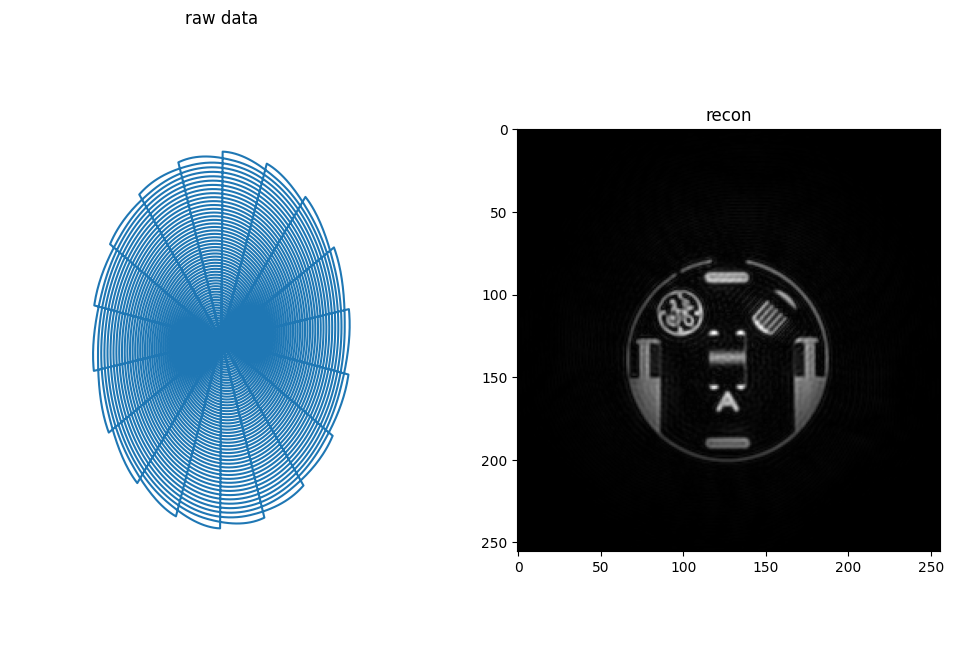

In [7]:
plt.figure(figsize =(12,8))
plt.subplot(1,2,1) 
plt.plot(trajectory[:,0], trajectory[:,1])
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.axis('off')
plt.subplot(1,2,2)
plt.title("recon")
plt.imshow(np.abs(((ifft2c(mat)))), cmap ="gray")
plt.gca().set_aspect('equal')